In [1]:
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon
import os

def analisar_diversidade_shapefile(caminho_arquivo_shp):
    """
    Lê um Shapefile e analisa sua diversidade em termos de tipos de geometria,
    complexidade e volume de feições.

    Args:
        caminho_arquivo_shp (str): O caminho completo para o arquivo .shp.
    """
    if not os.path.exists(caminho_arquivo_shp):
        print(f"Erro: Arquivo '{caminho_arquivo_shp}' não encontrado.")
        return

    try:
        gdf = geopandas.read_file(caminho_arquivo_shp)
        print(f"--- Análise de Diversidade do Shapefile: {os.path.basename(caminho_arquivo_shp)} ---")

        # 1. Número de Feições (Registros)
        num_feicoes = len(gdf)
        print(f"\n1. Número total de feições: {num_feicoes}")
        if num_feicoes == 0:
            print("   O Shapefile está vazio. Não é adequado para testes.")
            return

        # 2. Tipos de Geometria Presentes
        tipos_geometria_unicos = gdf.geometry.geom_type.unique()
        print(f"\n2. Tipos de geometria únicos encontrados: {', '.join(tipos_geometria_unicos)}")

        # Contagem de cada tipo para detalhamento
        contagem_tipos = gdf.geometry.geom_type.value_counts()
        print("\n   Contagem por tipo de geometria:")
        print(contagem_tipos)

        # 3. Análise da Complexidade das Geometrias (Contagem de Vértices)
        # Para Polígonos e Linhas, calcular a média de vértices
        complexidade_poligonos = []
        complexidade_linhas = []
        contagem_multi_geometrias = {
            'MultiPoint': 0,
            'MultiLineString': 0,
            'MultiPolygon': 0
        }

        for geom in gdf.geometry:
            if geom.geom_type == 'Polygon':
                # Conta vértices do anel exterior (primeiro) e anéis interiores (buracos)
                vertices = len(geom.exterior.coords)
                for interior in geom.interiors:
                    vertices += len(interior.coords)
                complexidade_poligonos.append(vertices)
            elif geom.geom_type == 'LineString':
                vertices = len(geom.coords)
                complexidade_linhas.append(vertices)
            elif geom.geom_type.startswith('Multi'):
                contagem_multi_geometrias[geom.geom_type] += 1
                # Para multi-geometrias, você pode querer analisar a complexidade de cada parte
                # Ex: for part in geom.geoms: analisar_complexidade_parte(part)
                # Por simplicidade aqui, apenas contamos a ocorrência da Multi-geometria.

        print("\n3. Análise de Complexidade das Geometrias:")
        if complexidade_poligonos:
            media_vertices_poligonos = sum(complexidade_poligonos) / len(complexidade_poligonos)
            print(f"   Média de vértices por Polígono: {media_vertices_poligonos:.2f}")
        if complexidade_linhas:
            media_vertices_linhas = sum(complexidade_linhas) / len(complexidade_linhas)
            print(f"   Média de vértices por LineString: {media_vertices_linhas:.2f}")
        
        print("\n   Ocorrência de Multi-Geometrias:")
        for geo_type, count in contagem_multi_geometrias.items():
            if count > 0:
                print(f"   - {geo_type}: {count} feições")

        # 4. Análise de Atributos (opcional, para diversidade de dados não-espaciais)
        num_colunas_atributos = len(gdf.columns) - 1 # Ignora a coluna 'geometry'
        print(f"\n4. Número de colunas de atributos: {num_colunas_atributos}")
        if num_colunas_atributos > 0:
            print("\n   Preview das primeiras 5 linhas dos atributos:")
            print(gdf.drop(columns=['geometry']).head())
        else:
            print("   Nenhuma coluna de atributo detectada além da geometria.")

        # 5. Visualização (opcional, mas muito útil para ter uma ideia visual)
        print("\n5. Gerando visualização prévia (pode demorar para arquivos grandes)...")
        try:
            # Para arquivos muito grandes, plotar pode ser lento ou consumir muita memória.
            # Limitar a plotagem a uma amostra ou área específica pode ser necessário.
            # Se for muito grande, plotar apenas os contornos ou uma amostra.
            if num_feicoes > 100000: # Limite arbitrário para evitar travamento
                print("   Arquivo muito grande para plotar todas as feições. Plotando apenas a caixa delimitadora (bounds).")
                fig, ax = plt.subplots(1, 1, figsize=(10, 10))
                gdf.unary_union.boundary.plot(ax=ax, color='blue')
                ax.set_title(f'Bounds do Shapefile: {os.path.basename(caminho_arquivo_shp)}')
            else:
                fig, ax = plt.subplots(1, 1, figsize=(10, 10))
                gdf.plot(ax=ax, color='blue', edgecolor='black', linewidth=0.5)
                ax.set_title(f'Preview do Shapefile: {os.path.basename(caminho_arquivo_shp)}')
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"   Não foi possível gerar a visualização: {e}")
            print("   Isso pode ocorrer com arquivos geoespaciais muito grandes ou complexos.")


    except Exception as e:
        print(f"Erro ao ler ou processar o Shapefile: {e}")
        print("Verifique se o arquivo SHP está completo (com .dbf, .shx, .prj, etc.)")



--- Análise de Diversidade do Shapefile: BR_Municipios_2024.shp ---

1. Número total de feições: 5573

2. Tipos de geometria únicos encontrados: Polygon, MultiPolygon

   Contagem por tipo de geometria:
Polygon         5468
MultiPolygon     105
Name: count, dtype: int64

3. Análise de Complexidade das Geometrias:
   Média de vértices por Polígono: 3162.32

   Ocorrência de Multi-Geometrias:
   - MultiPolygon: 105 feições

4. Número de colunas de atributos: 15

   Preview das primeiras 5 linhas dos atributos:
    CD_MUN                  NM_MUN  CD_RGI                 NM_RGI CD_RGINT  \
0  2504108            Carrapateira  250015             Cajazeiras     2504   
1  1718451                  Pugmil  170003   Paraíso do Tocantins     1701   
2  2104206                 Fortuna  210016       Presidente Dutra     2104   
3  5219902  São Francisco de Goiás  520002               Anápolis     5201   
4  2708600   São Miguel dos Campos  270004  São Miguel dos Campos     2701   

             NM_R

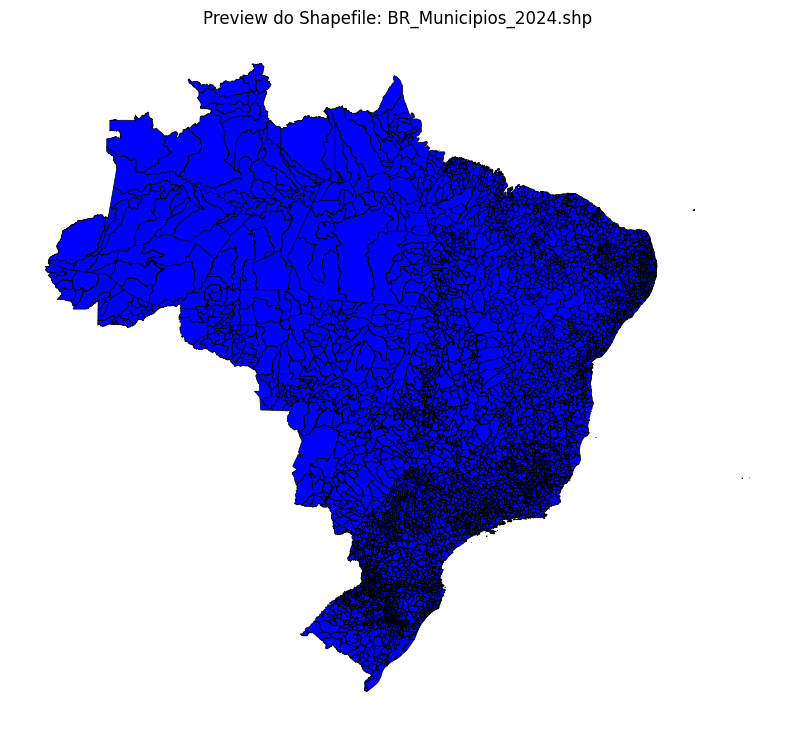

In [4]:
# --- Exemplo de Uso ---
# Substitua 'caminho/para/seu/arquivo.shp' pelo caminho real do seu Shapefile.
# Certifique-se de que o arquivo esteja no mesmo diretório do notebook, ou forneça o caminho completo.
# Exemplo para dados do IBGE:
# caminho_do_seu_shp = 'BR/UF/MALHA_SETOR_CENSITARIO_2010_UF.shp'
# caminho_do_seu_shp = 'Recife/Malha_Setor_Censitario_Urbano_Recife.shp'
caminho_do_seu_shp = 'BR_Municipios_2024/BR_Municipios_2024.shp' # <--- SUBSTITUA AQUI

analisar_diversidade_shapefile(caminho_do_seu_shp)